pmgus_vbeta.ipynb

In [84]:
import pandas as pd
import numpy as np
pd.set_option('display.colheader_justify', 'left')  # Left-align column headers
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
from datetime import datetime, timedelta
#
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz
from tqdm import tqdm  # Visualize loop progress
from sklearn.linear_model import LinearRegression
from tenacity import retry, stop_after_attempt, wait_fixed
import openpyxl
import os
import requests
import yfinance as yf

#
from dotenv import load_dotenv

data import (manual) TradingView

In [85]:
# base file path and file path setup
base_dir_path = '/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/pmgus_inputs/' 
tv_prefix = 'tv_screen_gap-up_'
file_type_csv = '.csv'
#####---------------------#####
# screen_date = '2024-12-17'
# screen_date = '2024-12-18'
screen_date = '2024-12-20'

#####---------------------#####
tv_filename = base_dir_path + tv_prefix + screen_date + file_type_csv

# READ
trading_view_df = pd.read_csv(tv_filename)

# PRINT
print(tv_filename)
print(len(trading_view_df))
# print first 5 ticker Symbols only
print(trading_view_df['Symbol'].head(5))

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/pmgus_inputs/tv_screen_gap-up_2024-12-20.csv
1014
0      AVGO
1       LLY
2         V
3        MA
4    BML/PL
Name: Symbol, dtype: object


| initial screener |
|-|
setup market cap category groups, criteria configurations, and conditional filtering.

In [86]:
# CREATE CATEGORIES FOR MARKET CAP
def categorize_market_cap(df):
    # categorize stocks groups by market cap
    df['Market capitalization'] = pd.to_numeric(df['Market capitalization'], errors='coerce')
    conditions = [
        (df['Market capitalization'] >= 200_000_000_000),  # Titans
        (df['Market capitalization'] >= 10_000_000_000) & (df['Market capitalization'] < 200_000_000_000),  # Large caps
        (df['Market capitalization'] >= 2_000_000_000) & (df['Market capitalization'] < 10_000_000_000),  # Mid caps
        (df['Market capitalization'] >= 300_000_000) & (df['Market capitalization'] < 2_000_000_000),  # Small caps
        (df['Market capitalization'] > 50_000_000) & (df['Market capitalization'] < 300_000_000),  # Micro caps
        (df['Market capitalization'] <= 50_000_000)  # Shrimp
    ]
    # marekt cap categories list
    categories = ['Titans', 'Large caps', 'Mid caps', 'Small caps', 'Micro caps', 'Shrimp']
    df['marketCapType'] = np.select(conditions, categories, default='Undefined')
    return df
# execute categorization
category_setup_df = categorize_market_cap(trading_view_df).copy()
# drop Undefined marketCapType
category_setup_df = category_setup_df[category_setup_df['marketCapType'] != 'Undefined']

# convert necessary columns to numeric
def convert_columns_to_numeric(df, columns):
    """Convert specified columns to numeric types."""
    for col in columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

# list of columns to convert
numeric_columns = [
    'Market capitalization', 'Float shares outstanding', 'Relative Volume 1 day',
    'Relative Volume at Time', 'Pre-market Change %', 'Pre-market Gap %',
    'Price', 'Volume Weighted Average Price 1 day', 'Volatility 1 day',
    'Volatility 1 week', 'Volatility 1 month', 'Pre-market Volume'
]

# apply conversion
category_setup_df = convert_columns_to_numeric(category_setup_df, numeric_columns)

# CRITERIA CONFIGURATION FOR EACH MARKET CAP CATEGORY
criteria_config = {
    "Titans": {
        "pre_market_change_pct_threshold": 0.002,  # 0.2% for Titans
        "float_shares_outstanding_threshold": 1_000_000_000,  # 1 billion shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.03,
        "pre_market_gap_percentage_threshold": 0.001,  # 0.1%
        "pre_market_vwap_drawdown_threshold": 0.003,  # 0.3% drawdown from VWAP
        "pre_market_volume_threshold": 50_000  # Minimum pre-market volume
    },
    "Large caps": {
        "pre_market_change_pct_threshold": 0.005,  # 0.5% for Large caps
        "float_shares_outstanding_threshold": 200000000,  # 200 million shares
        "relative_volume_threshold": 1.3,  # More inclusive
        "relative_volume_at_time_threshold": 0.04,  # More inclusive
        "pre_market_gap_percentage_threshold": 0.005,  # 0.5%
        "pre_market_vwap_drawdown_threshold": 0.004,  # 0.4% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Midlers": { 
        "pre_market_change_pct_threshold": 0.02,  # 2% for Midlers 
        "float_shares_outstanding_threshold": 50000000,  # 50 million shares
        "relative_volume_threshold": 1.3,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.02,
        "pre_market_vwap_drawdown_threshold": 0.005,  # 0.5% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Small caps": {
        "pre_market_change_pct_threshold": 0.03,  # 3% for Small caps
        "float_shares_outstanding_threshold": 20000000,  # 20 million shares
        "relative_volume_threshold": 1.2,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.03,
        "pre_market_vwap_drawdown_threshold": 0.006,  # 0.6% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Micro caps": {
        "pre_market_change_pct_threshold": 0.04,  # 4% for Micro caps
        "float_shares_outstanding_threshold": 5000000,  # 5 million shares
        "relative_volume_threshold": 1.1,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.04,
        "pre_market_vwap_drawdown_threshold": 0.007,  # 0.7% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    },
    "Shrimp": {
        "pre_market_change_pct_threshold": 0.05,  # 5% for Shrimp
        "float_shares_outstanding_threshold": 1000000,  # 1 million shares
        "relative_volume_threshold": 1.0,
        "relative_volume_at_time_threshold": 0.05,
        "pre_market_gap_percentage_threshold": 0.05,
        "pre_market_vwap_drawdown_threshold": 0.008, # 0.8% drawdown from VWAP
        "pre_market_volume_threshold": 50000  # Minimum pre-market volume
    }
}

# FILTER STOCKS BASED ON CONFIGURATION CRITERIA - STAGING
def filter_stocks(df, config):
    # stock filtering conditions >=< based on criteria
    conditions = (
        (df['Pre-market Change %'] >= config.get('pre_market_change_pct_threshold', 0)) &
        (df['Float shares outstanding'] <= config.get('float_shares_outstanding_threshold', float('inf'))) &
        (df['Relative Volume 1 day'] >= config.get('relative_volume_threshold', 0)) &
        (df['Relative Volume at Time'] >= config.get('relative_volume_at_time_threshold', 0)) &
        (df['Pre-market Gap %'] >= config.get('pre_market_gap_percentage_threshold', 0)) &
        (df['Price'] >= df['Volume Weighted Average Price 1 day'] * (1 - config.get('pre_market_vwap_drawdown_threshold', 0))) &
        (df['Volatility 1 day'] >= df['Volatility 1 week']) &
        (df['Volatility 1 day'] >= df['Volatility 1 month']) &
        (df['Pre-market Volume'] >= config.get('pre_market_volume_threshold', 0))
    )
    return df[conditions]

# SCREEN STOCKS BY CATEGORY
def screen_stocks_by_category(df, category):
    """Filter stocks in a category using predefined criteria."""
    config = criteria_config.get(category, {})
    filtered_df = filter_stocks(df, config)
    return filtered_df

# EXECUTE KEY SCREENING FUNCTION AND CREATE DATAFRAME
smash_df = pd.DataFrame()
categories = category_setup_df['marketCapType'].unique()

for category in categories:
    category_df = category_setup_df[category_setup_df['marketCapType'] == category]
    gap_up_stage_df = screen_stocks_by_category(category_df, category)
    smash_df = pd.concat([smash_df, gap_up_stage_df], ignore_index=True)

# rendered column list and ordering
cols_list = [
    'Symbol', 
    'Description', 
    'marketCapType', 
    'Pre-market Change %', 
    'Pre-market Gap %', 
    'marketCapType',
    'Market capitalization',
    'Price', 
    'Pre-market Open', 
    'Industry', 
    'Index', 
    'Sector', 
    'Exchange',
    'Recent earnings date', 
    'Upcoming earnings date', 
    'Float shares outstanding', 
    'Average Volume 10 days',
    'Average Volume 30 days', 
    'Average Volume 90 days',
    'Relative Volume 1 day', 
    'Relative Volume 5 minutes', 
    'Relative Volume 30 minutes', 
    'Relative Volume at Time', 
    'Analyst Rating',
    'Technical Rating 5 minutes'
]

# filter columns to only include those present in the DataFrame
existing_cols = [col for col in cols_list if col in smash_df.columns]
smash_df = smash_df[existing_cols]

# sort and reset index
smash_df = smash_df.sort_values(
    by=['Pre-market Change %', 'Price'],
    ascending=[False, False]).reset_index(drop=True)

print(f"{smash_df.shape[0]} stocks found.")

12 stocks found.


| quick and dirty filter |
|-|

think abdout adding float????

In [87]:
# quick and dirty filter for high-probability morning momentum trades (Re: Pre-market Gap Up)
def quick_dirty_filter(df):
    return df[
        # strong pre-market movement but not overextended
        (
            (df['Pre-market Change %'] > 3.0) |
            ((df['Pre-market Change %'] > 1.5) & (df['Relative Volume 5 minutes'] > 5.0))
        ) &
        # volume validation
        (df['Relative Volume 5 minutes'] > 2.0) &
        # industry/sector grouping
        (df.groupby('Industry')['Pre-market Change %'].transform('count') > 1)
            ].sort_values('Pre-market Change %', ascending=False)

In [88]:
# EXECUTE quick and dirty filter && CREATE a df and list
quick_dirty_df = quick_dirty_filter(smash_df)
quick_dirty_list = quick_dirty_df['Symbol'].to_list()

# PRINT
print(f'{len(quick_dirty_df)} stocks returned from the quick and dirty filter.')
# print(smash_qd_df.columns)
print(quick_dirty_list)
# display(smash_qd_df)
display(quick_dirty_df.head(2))


1 stocks returned from the quick and dirty filter.
['OGE']


,Symbol,Description,marketCapType,Pre-market Change %,Pre-market Gap %,marketCapType,Market capitalization,Price,Pre-market Open,Industry,Index,Sector,Exchange,Recent earnings date,Upcoming earnings date,Float shares outstanding,Average Volume 10 days,Average Volume 30 days,Average Volume 90 days,Relative Volume 1 day,Relative Volume 5 minutes,Relative Volume 30 minutes,Relative Volume at Time,Analyst Rating,Technical Rating 5 minutes
1,OGE,OGE Energy Corp,Mid caps,2.539062,2.539062,Mid caps,8.230825e+09,40.96,42.0,Electric utilities,"S&P MidCap 400, Russell 3000, Russell 1000",Utilities,NYSE,2024-11-05,2025-02-20,2.000226e+08,1009721.6,1075709.2,1.013390e+06,1.045604,7.823327,5.426505,1.243039,Neutral,Strong sell


save stock(s) results (output) to .csv

In [89]:
# string object for quick and dirty results .csv
smash_qd_results_filename = (f"{base_dir_path}smash_quick_dirty_results_{screen_date}{file_type_csv}")
print(smash_qd_results_filename)

# SAVE TO CSV
quick_dirty_df.to_csv(smash_qd_results_filename, index=False)

/Users/sudz4/Desktop/SPS_local/sps/x_pre_market_gap_up_screener/pmgus_inputs/smash_quick_dirty_results_2024-12-20.csv


historical price data
w/tradingview open source chart

| END OF DAY (EOD) |
|-

| START performance (back)testing |
|-

In [90]:
print(len(quick_dirty_list))
print(len(quick_dirty_df))
print(quick_dirty_list)

1
1
['OGE']


plot #1; SINGLE stock, one (1) day, intraday price action.

In [91]:
def plot_single_stock(symbols_list, target_date):####---------------------#####
    """
    Creates a single stock plot with price action, volume, and annotations.
    Takes the first stock from the provided list.
    
    Parameters:
    symbols_list (list): List of stock symbols (will use first one)
    target_date (str or datetime): The target date to analyze
    """
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    #### Get first stock from list
    symbol = symbols_list[0]
    #### --------------------- ####
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Get data
    ticker = yf.Ticker(symbol)
    prev_data = ticker.history(start=prev_day, end=target_date, interval='1d')
    today_data = ticker.history(start=target_date, 
                              end=target_date + pd.DateOffset(days=1), 
                              interval='1m')
    
    if today_data.empty:
        ax1.text(0.5, 0.5, f"No data available for {symbol}\non {target_date.date()}", 
                ha='center', va='center')
        plt.show()
        return
    
    # Timezone handling
    if today_data.index.tz is not None:
        today_data.index = today_data.index.tz_convert('US/Eastern')
    else:
        today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
    
    today_data = today_data.between_time('9:30', '16:00')
    
    # Calculate first 10 minutes for low and first hour for high
    first_10min_data = today_data.between_time('9:30', '9:40')
    first_hour_data = today_data.between_time('9:30', '10:30')
    
    if not first_hour_data.empty and not first_10min_data.empty:
        first_10min_low = first_10min_data['Low'].min()
        low_timestamp = first_10min_data[first_10min_data['Low'] == first_10min_low].index[0]
        
        first_hour_high = first_hour_data['High'].max()
        high_timestamp = first_hour_data[first_hour_data['High'] == first_hour_high].index[0]
        
        first_hour_gain_pct = ((first_hour_high - first_10min_low) / first_10min_low) * 100
    else:
        first_hour_gain_pct = 0.0
    
    # Plot price action
    ax1.plot(today_data.index, today_data['Close'], 
            color='white', linewidth=1.5, label='Price')
    
    # Calculate levels
    today_open = today_data['Open'].iloc[0]
    today_high = today_data['High'].max()
    today_low = today_data['Low'].min()
    today_close = today_data['Close'].iloc[-1]
    
    # Calculate and set y-axis limits
    if not prev_data.empty:
        prev_day_high = prev_data['High'].iloc[-1]
        prev_day_low = prev_data['Low'].iloc[-1]
        prev_day_close = prev_data['Close'].iloc[-1]
        
        all_price_levels = [
            prev_day_high, prev_day_low, prev_day_close,
            today_high, today_low, today_open, today_close
        ]
        
        min_price = min(all_price_levels)
        max_price = max(all_price_levels)
        price_range = max_price - min_price
        padding = price_range * 0.1
        
        ax1.set_ylim(min_price - padding, max_price + padding)
        
        # Draw price levels with reduced alpha
        ax1.axhline(y=prev_day_high, color='red', linestyle='--', alpha=0.3)
        ax1.axhline(y=prev_day_low, color='green', linestyle='--', alpha=0.3)
        ax1.axhline(y=prev_day_close, color='yellow', linestyle='--', alpha=0.3)
        
        # Add labels with smaller font
        label_offset = price_range * 0.02
        ax1.text(today_data.index[-1], prev_day_high + label_offset, 
                f' PDH: ${prev_day_high:.2f}', color='red', alpha=0.8, 
                va='bottom', ha='left', fontsize=7)
        ax1.text(today_data.index[-1], prev_day_low - label_offset, 
                f' PDL: ${prev_day_low:.2f}', color='green', alpha=0.8, 
                va='top', ha='left', fontsize=7)
        ax1.text(today_data.index[-1], prev_day_close, 
                f' PDC: ${prev_day_close:.2f}', color='yellow', alpha=0.8, 
                va='center', ha='left', fontsize=7)
        
        # Add arrows and timestamps for first hour range
        if not first_hour_data.empty and not first_10min_data.empty:
            # Add arrow and timestamp for 10min low (red)
            ax1.annotate(f'${first_10min_low:.2f}\n{low_timestamp.strftime("%H:%M")}', 
                        xy=(low_timestamp, first_10min_low),
                        xytext=(low_timestamp, first_10min_low - (price_range * 0.03)),
                        color='red', alpha=0.9, fontsize=7,
                        ha='center', va='top',
                        arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, linewidth=2))
            
            # Add arrow and timestamp for hour high (green)
            ax1.annotate(f'${first_hour_high:.2f}\n{high_timestamp.strftime("%H:%M")}',
                        xy=(high_timestamp, first_hour_high),
                        xytext=(high_timestamp, first_hour_high + (price_range * 0.03)),
                        color='green', alpha=0.9, fontsize=7,
                        ha='center', va='bottom',
                        arrowprops=dict(arrowstyle='simple', color='green', alpha=0.8, linewidth=2))
    
    # Plot volume
    colors = ['red' if close < open else '#00ff00' 
             for close, open in zip(today_data['Close'], today_data['Open'])]
    ax2.bar(today_data.index, today_data['Volume'], 
            color=colors, alpha=0.7, width=0.5/(len(today_data.index)))
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
        ax.grid(True, alpha=0.15)
        ax.set_xlim(today_data.index[0] - pd.Timedelta(minutes=5),
                   today_data.index[-1] + pd.Timedelta(minutes=5))
    
    ax1.set_xticklabels([])
    
    # Add title and labels
    if not prev_data.empty:
        gap_pct = (today_open - prev_day_close) / prev_day_close * 100
        title = f'${symbol} G:{gap_pct:+.1f}% | 10m→1h:{first_hour_gain_pct:+.1f}%'
    else:
        title = f'${symbol}'
    
    ax1.set_title(title, fontsize=10, pad=8)
    ax1.set_ylabel('Price ($)', fontsize=8)
    ax2.set_ylabel('Volume', fontsize=8)
    
    # Add last price
    ax1.text(today_data.index[-1], today_close, f'Last: ${today_close:.2f}', 
             color='white', fontsize=7, va='center', ha='left')
    
    plt.show()
    return None

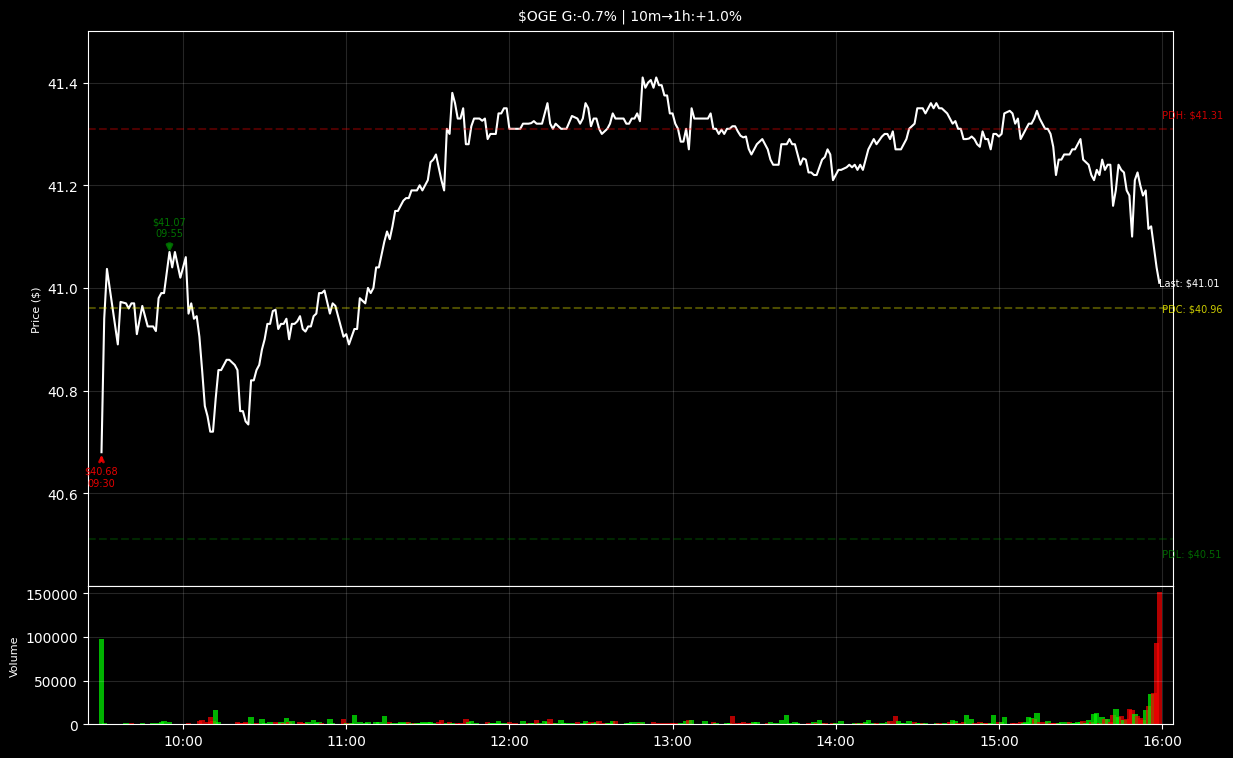

In [92]:
#### plot #1; SINGLE stock, one (1) day, intraday price action. ####
plot_single_stock(quick_dirty_list, screen_date)

plot #2; MULTI-stock intraday price action grid of subplots.

In [93]:
def plot_multiple_stocks_grid(symbols_list, target_date):
    """
    Creates a grid of subplots showing price action for multiple stocks.
    Each stock gets its own price and volume panel with full annotations.
    """
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    # Calculate grid dimensions
    n_stocks = len(symbols_list)
    n_cols = min(2, n_stocks)
    n_rows = (n_stocks + n_cols - 1) // n_cols
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14 * n_cols, 9 * n_rows))
    outer_grid = fig.add_gridspec(n_rows, n_cols, hspace=0.25, wspace=0.2)
    
    for idx, symbol in enumerate(symbols_list):
        row = idx // n_cols
        col = idx % n_cols
        inner_grid = outer_grid[row, col].subgridspec(2, 1, height_ratios=[4, 1], hspace=0)
        ax1 = fig.add_subplot(inner_grid[0])
        ax2 = fig.add_subplot(inner_grid[1])
        
        # Get data
        ticker = yf.Ticker(symbol)
        prev_data = ticker.history(start=prev_day, end=target_date, interval='1d')
        today_data = ticker.history(start=target_date, 
                                  end=target_date + pd.DateOffset(days=1), 
                                  interval='1m')
        
        if today_data.empty:
            ax1.text(0.5, 0.5, f"No data available for {symbol}\non {target_date.date()}", 
                    ha='center', va='center')
            continue
        
        # Timezone handling
        if today_data.index.tz is not None:
            today_data.index = today_data.index.tz_convert('US/Eastern')
        else:
            today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
        
        today_data = today_data.between_time('9:30', '16:00')
        
        # Calculate first 10 minutes for low and first hour for high
        first_10min_data = today_data.between_time('9:30', '9:40')
        first_hour_data = today_data.between_time('9:30', '10:30')
        
        if not first_hour_data.empty and not first_10min_data.empty:
            # Find low in first 10 minutes
            first_10min_low = first_10min_data['Low'].min()
            low_timestamp = first_10min_data[first_10min_data['Low'] == first_10min_low].index[0]
            
            # Find high in first hour
            first_hour_high = first_hour_data['High'].max()
            high_timestamp = first_hour_data[first_hour_data['High'] == first_hour_high].index[0]
            
            first_hour_gain_pct = ((first_hour_high - first_10min_low) / first_10min_low) * 100
        else:
            first_hour_gain_pct = 0.0
        
        # Plot price action
        ax1.plot(today_data.index, today_data['Close'], 
                color='white', linewidth=1.5, label='Price')
        
        # Calculate levels
        today_open = today_data['Open'].iloc[0]
        today_high = today_data['High'].max()
        today_low = today_data['Low'].min()
        today_close = today_data['Close'].iloc[-1]
        
        # Calculate and set y-axis limits
        if not prev_data.empty:
            prev_day_high = prev_data['High'].iloc[-1]
            prev_day_low = prev_data['Low'].iloc[-1]
            prev_day_close = prev_data['Close'].iloc[-1]
            
            all_price_levels = [
                prev_day_high, prev_day_low, prev_day_close,
                today_high, today_low, today_open, today_close
            ]
            
            min_price = min(all_price_levels)
            max_price = max(all_price_levels)
            price_range = max_price - min_price
            padding = price_range * 0.1
            
            ax1.set_ylim(min_price - padding, max_price + padding)
            
            # Draw price levels with reduced alpha
            ax1.axhline(y=prev_day_high, color='red', linestyle='--', alpha=0.3)
            ax1.axhline(y=prev_day_low, color='green', linestyle='--', alpha=0.3)
            ax1.axhline(y=prev_day_close, color='yellow', linestyle='--', alpha=0.3)
            
            # Add labels with smaller font
            label_offset = price_range * 0.02
            ax1.text(today_data.index[-1], prev_day_high + label_offset, 
                    f' PDH: ${prev_day_high:.2f}', color='red', alpha=0.8, 
                    va='bottom', ha='left', fontsize=7)
            ax1.text(today_data.index[-1], prev_day_low - label_offset, 
                    f' PDL: ${prev_day_low:.2f}', color='green', alpha=0.8, 
                    va='top', ha='left', fontsize=7)
            ax1.text(today_data.index[-1], prev_day_close, 
                    f' PDC: ${prev_day_close:.2f}', color='yellow', alpha=0.8, 
                    va='center', ha='left', fontsize=7)
            
            # Add arrows and timestamps for first hour range
            if not first_hour_data.empty and not first_10min_data.empty:
                # Add arrow and timestamp for 10min low (red)
                ax1.annotate(f'${first_10min_low:.2f}\n{low_timestamp.strftime("%H:%M")}', 
                            xy=(low_timestamp, first_10min_low),
                            xytext=(low_timestamp, first_10min_low - (price_range * 0.03)),
                            color='red', alpha=0.9, fontsize=7,
                            ha='center', va='top',
                            arrowprops=dict(arrowstyle='->', color='red', alpha=0.8, linewidth=2))
                
                # Add arrow and timestamp for hour high (green)
                ax1.annotate(f'${first_hour_high:.2f}\n{high_timestamp.strftime("%H:%M")}',
                            xy=(high_timestamp, first_hour_high),
                            xytext=(high_timestamp, first_hour_high + (price_range * 0.03)),
                            color='green', alpha=0.9, fontsize=7,
                            ha='center', va='bottom',
                            arrowprops=dict(arrowstyle='simple', color='green', alpha=0.8, linewidth=2))
        
        # Plot volume
        colors = ['red' if close < open else '#00ff00' 
                 for close, open in zip(today_data['Close'], today_data['Open'])]
        ax2.bar(today_data.index, today_data['Volume'], 
                color=colors, alpha=0.7, width=0.5/(len(today_data.index)))
        
        # Format axes
        for ax in [ax1, ax2]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
            ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
            ax.grid(True, alpha=0.15)
            ax.set_xlim(today_data.index[0] - pd.Timedelta(minutes=5),
                       today_data.index[-1] + pd.Timedelta(minutes=5))
        
        ax1.set_xticklabels([])
        
        # Add title and labels
        if not prev_data.empty:
            gap_pct = (today_open - prev_day_close) / prev_day_close * 100
            title = f'${symbol} G:{gap_pct:+.1f}% | 10m→1h:{first_hour_gain_pct:+.1f}%'
        else:
            title = f'${symbol}'
        
        ax1.set_title(title, fontsize=9, pad=8)
        ax1.set_ylabel('Price ($)', fontsize=8)
        ax2.set_ylabel('Volume', fontsize=8)
        
        # Add last price
        ax1.text(today_data.index[-1], today_close, f'Last: ${today_close:.2f}', 
            color='white', fontsize=7, va='center', ha='left')
    
    plt.show()

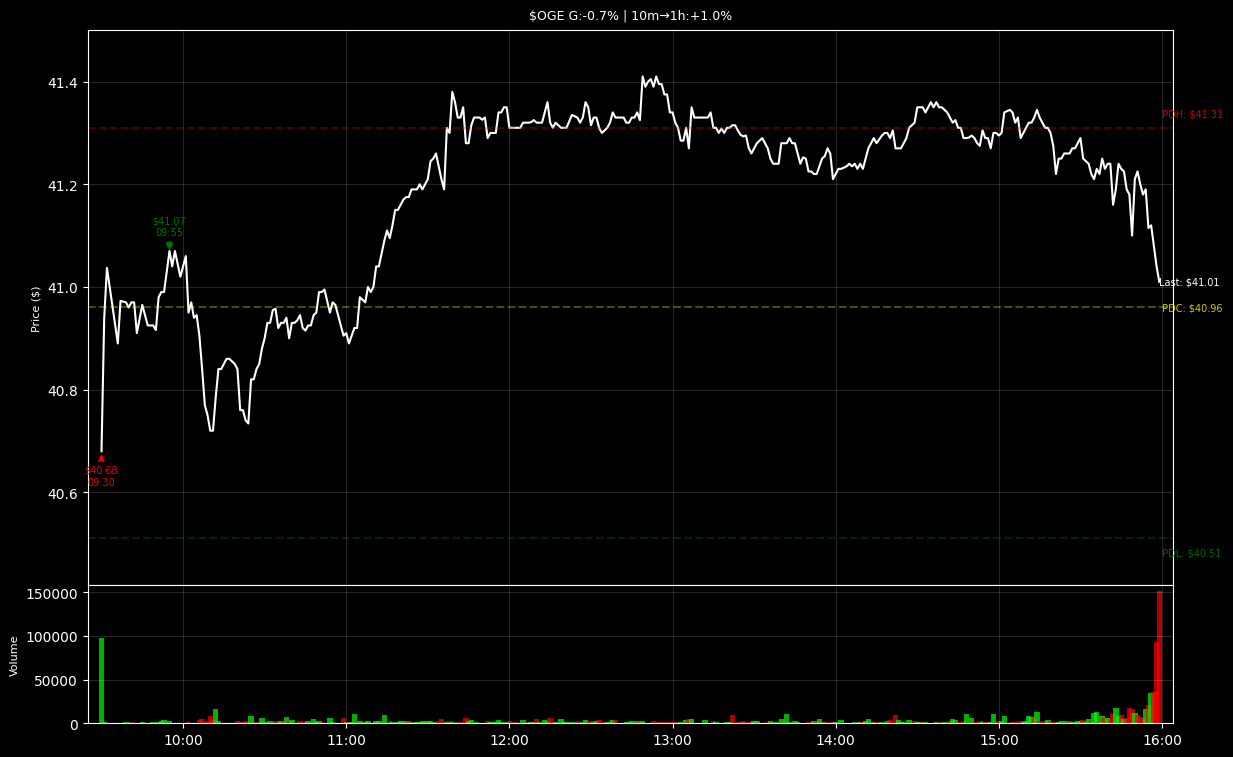

In [94]:
#### plot #2; MULTI-stock intraday price action grid of subplots. ####
plot_multiple_stocks_grid(quick_dirty_list, screen_date)

plot #3; overlay stock prices %.

In [95]:
def plot_multiple_daily_price_levels(symbols_list, target_date):
    target_date = pd.to_datetime(target_date)
    prev_day = target_date - pd.DateOffset(days=1)
    
    plt.style.use('dark_background')
    fig = plt.figure(figsize=(14, 9))
    gs = fig.add_gridspec(2, 1, height_ratios=[4, 1], hspace=0)
    ax1 = fig.add_subplot(gs[0])
    ax2 = fig.add_subplot(gs[1])
    
    # Generate distinct colors for each stock
    colors = plt.cm.rainbow(np.linspace(0, 1, len(symbols_list)))
    
    # Store min/max percentage changes for y-axis scaling
    all_changes = []
    
    for symbol, color in zip(symbols_list, colors):
        ticker = yf.Ticker(symbol)
        
        # Get data
        today_data = ticker.history(start=target_date, 
                                  end=target_date + pd.DateOffset(days=1), 
                                  interval='1m')
        
        if today_data.empty:
            print(f"No data available for {symbol} on {target_date.date()}")
            continue
            
        # Timezone handling
        if today_data.index.tz is not None:
            today_data.index = today_data.index.tz_convert('US/Eastern')
        else:
            today_data.index = today_data.index.tz_localize('UTC').tz_convert('US/Eastern')
        
        # Filter market hours
        today_data = today_data.between_time('9:30', '16:00')
        
        if len(today_data) == 0:
            continue
            
        # Calculate percentage change from open
        open_price = today_data['Open'].iloc[0]
        today_data['pct_change'] = ((today_data['Close'] - open_price) / open_price) * 100
        
        # Plot price action as percentage change
        line = ax1.plot(today_data.index, today_data['pct_change'],
                       color=color, linewidth=1.5, label=f'${symbol}')
        
        # Store data for y-axis scaling
        all_changes.extend(today_data['pct_change'].tolist())
        
        # Plot volume
        ax2.bar(today_data.index, today_data['Volume'],
                color=color, alpha=0.3, width=0.7/(len(today_data.index)))
    
    # Set y-axis limits with padding
    if all_changes:
        change_range = max(all_changes) - min(all_changes)
        padding = change_range * 0.1
        ax1.set_ylim(min(all_changes) - padding, max(all_changes) + padding)
    
    # Format axes
    for ax in [ax1, ax2]:
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone('US/Eastern')))
        ax.xaxis.set_major_locator(mdates.HourLocator(interval=1, tz=pytz.timezone('US/Eastern')))
        ax.grid(True, alpha=0.15)
    
    # Remove x-axis labels from top subplot
    ax1.set_xticklabels([])
    
    # Customize appearance
    fig.suptitle(f'Multiple Stock Comparison - {target_date.strftime("%Y-%m-%d")}',
                 y=0.95, fontsize=12)
    ax1.set_ylabel('% Change from Open', fontsize=10)
    ax2.set_ylabel('Volume', fontsize=10)
    
    # Add legend
    ax1.legend(loc='upper left', bbox_to_anchor=(0, 1),
              ncol=len(symbols_list)//2 + 1)
    
    plt.show()

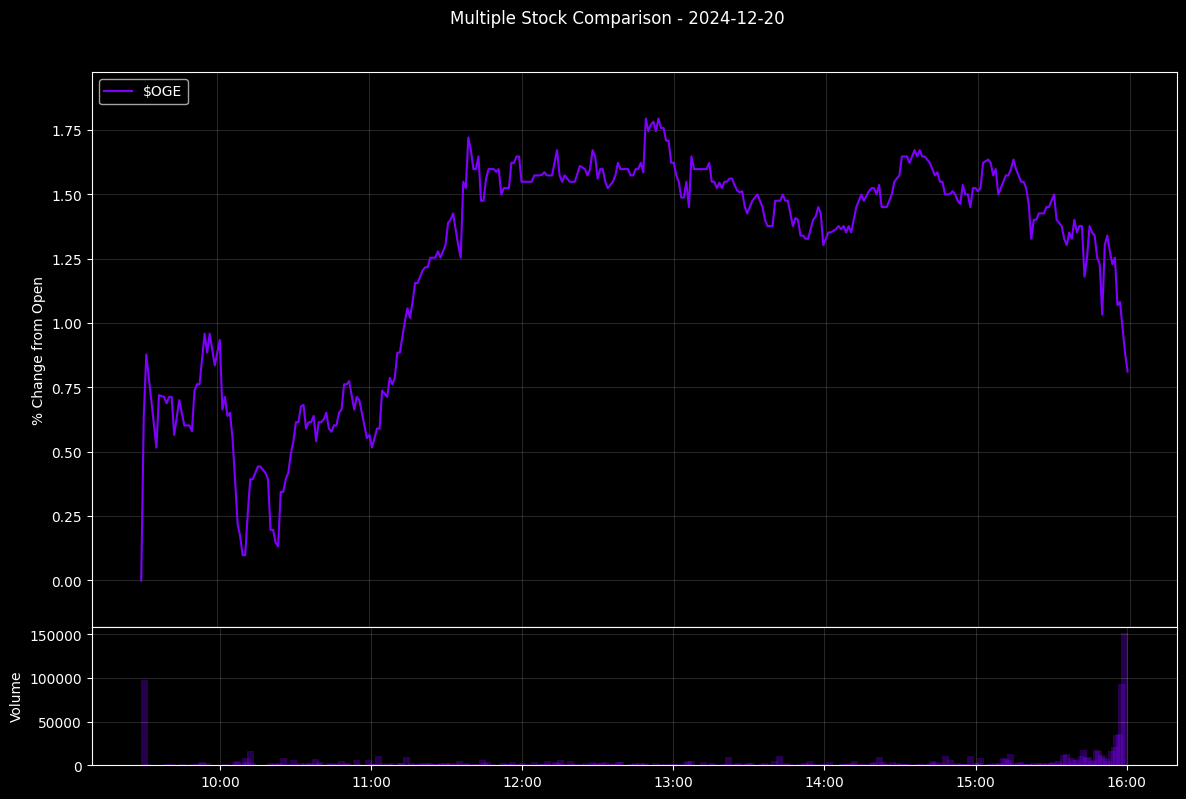

In [96]:
#### plot #3; overlay stock prices %. ####
plot_multiple_daily_price_levels(quick_dirty_list, screen_date)